In [516]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from math import sin, cos

import torch
from torch.autograd import grad

import sys
sys.path.append("../../../modules/")
# from simpleDDP import *
import sim2d2link as sim

In [517]:
def additional_move(a):
    return a

def f(x, a):
    return x+additional_move(a)

def x2p(x1, x2):
    p1 = torch.cos(x1) + torch.cos(x1+x2)
    p2 = torch.sin(x1) + torch.sin(x1+x2)
    return p1, p2

def r(x1, x2, p_true):
    p1, p2 = x2p(x1, x2)
    cost = (p1-p_true[0])**2 + (p2-p_true[1])**2
    return cost

In [518]:
init_value = torch.ones(1)*1.
np_true = node(torch.ones(2,1)*3.)
nx01, nx02 = node(init_value), node(init_value)
na01, na02 = node(init_value), node(init_value)
ex01, ex02 = f(nx01, na01), f(nx02, na02)
r0 = r(ex01, ex02, np_true)
grad(r0, nx01)[0]
# nx01.grad

tensor([7.3337])

In [519]:
def init_state(N, init_x):
    one = torch.ones(1)*1.
    zero = torch.zeros(1)

    nx = [[node(zero) for j in range(2)] for i in range(N+1)]
    ex = [[node(zero) for j in range(2)] for i in range(N)]
    er = [node(zero) for i in range(N+1)]

    fx = [torch.zeros(2, 2) for i in range(N)]
    fa = [torch.zeros(2, 2) for i in range(N)]
    rx = [torch.zeros(2, 1) for i in range(N+1)]
    sigma = [torch.zeros(2, 1) for i in range(N+1)]
    ja = [torch.zeros(2, 1) for i in range(N)]
    
    return nx, ex, er, fx, fa, rx, sigma, ja

In [520]:
def record(nx, ex, na, er, fx, fa, rx, sigma, ja, item_only=True):    
    df = pd.DataFrame({"nx": nx,"ex":ex+[[""]],"na":na+[[""]],"er":er,"fx":fx+[[""]],"fa":fa+[[""]],
                                     "rx":rx,"sigma":sigma,"ja":ja+[[""]]})
#     if item_only: df=df.applymap(lambda x: x[0].item() if x[0]!="" else np.nan)
        
    return df

In [521]:
def solve(f, r, n_roop, time_length, p_trues, eta=0.01, init_x=torch.zeros(2,1), adim=2, init_a_range=2.0, clip_a_value=None, mode_ascent=True, item_only=True, stack_log=False):
    N = time_length
    na = [[node(torch.empty(1).uniform_(-init_a_range, init_a_range)) for j in range(adim)] for i in range(N)]
    logs = []
    for roop in range(n_roop):
        if stack_log: logs.append(record(nx, ex, na, er, fx, fa, rx, sigma, ja, item_only=item_only))
        nx, ex, er, fx, fa, rx, sigma, ja = init_state(N, init_x)
        forward(f, r, nx, ex, na, fx, fa, er, rx, p_trues)
        backward(na, fx, fa, rx, sigma, ja, eta, clip_a_value, mode_ascent)
     
    logs.append(record(nx, ex, na, er, fx, fa, rx, sigma, ja, item_only=item_only))
    return logs

In [522]:
def forward(f, r, nx, ex, na, fx, fa, er, rx, p_trues):
    N = len(na)
    for i in range(N):
        p_true = p_trues[i]
        for j in range(2):
            ex[i][j] = f(nx[i][j], na[i][j])
            nx[i+1][j] = node(ex[i][j])
        er[i+1] = r(nx[i+1][0], nx[i+1][1], p_true)
        for j in range(2):
            rx[i+1][j] = grad(er[i+1], nx[i+1][j], retain_graph=True)[0]
            for k in range(2):
                fx[i][j][k] = grad(ex[i][k], nx[i][j], allow_unused=True)[0] if grad(ex[i][k], nx[i][j], allow_unused=True)[0] != None else 0
                fa[i][j][k] = grad(ex[i][k], na[i][j], allow_unused=True)[0] if grad(ex[i][k], na[i][j], allow_unused=True)[0] != None else 0

In [523]:
def backward(na, fx, fa, rx, sigma, ja, eta, clip_a_value, mode_ascent):
    N = len(fx)
    for i in range(N-1,-1,-1):
        sigma[i] = fx[i+1]@sigma[i+1]+rx[i+1] if i!=N-1 else rx[i+1]
        ja[i] = fa[i]@sigma[i]
        na[i] = optimize(na[i], ja[i], eta, clip_a_value, mode_ascent)

In [524]:
def optimize(na, ja, eta, clip_a_value, mode_ascent):
    next_na = [a + b for a, b in zip(na, list(eta*ja))] if mode_ascent else [a - b for a, b in zip(na, list(eta*ja))]
    if clip_a_value!=None: next_na = torch.clamp(next_na, -clip_a_value, clip_a_value)
        
    return next_na

In [562]:
p_trues = [torch.tensor([[1.], [1.]]), torch.tensor([[0.], [2.]]), torch.tensor([[-1.], [1.]])]

logs = solve(
    f, r, time_length=3, adim=2, 
    p_trues=p_trues, eta=5e-2, n_roop=300, 
    mode_ascent=False)
logs[-1]

,nx,ex,na,er,fx,fa,rx,sigma,ja
0,"[[tensor(0., grad_fn=<SelectBackward>)], [tens...","[[tensor(1.5686, grad_fn=<SelectBackward>)], [...","[[tensor(1.5686, grad_fn=<SelectBackward>)], [...","[tensor(0., grad_fn=<SelectBackward>)]","[[tensor(1.), tensor(0.)], [tensor(0.), tensor...","[[tensor(1.), tensor(0.)], [tensor(0.), tensor...","[[tensor(0.)], [tensor(0.)]]","[[tensor(4.5119e-05)], [tensor(-7.5453e-05)]]","[[tensor(4.5119e-05)], [tensor(-7.5453e-05)]]"
1,"[[tensor(1.5686, grad_fn=<SelectBackward>)], [...","[[tensor(1.7299, grad_fn=<SelectBackward>)], [...","[[tensor(0.1613, grad_fn=<SelectBackward>)], [...","[tensor(7.1277e-06, grad_fn=<SelectBackward>)]","[[tensor(1.), tensor(0.)], [tensor(0.), tensor...","[[tensor(1.), tensor(0.)], [tensor(0.), tensor...","[[tensor(-0.0015)], [tensor(0.0030)]]","[[tensor(0.0015)], [tensor(-0.0030)]]","[[tensor(0.0015)], [tensor(-0.0030)]]"
2,"[[tensor(1.7299, grad_fn=<SelectBackward>)], [...","[[tensor(3.1391, grad_fn=<SelectBackward>)], [...","[[tensor(1.4092, grad_fn=<SelectBackward>)], [...","[tensor(0.0006, grad_fn=<SelectBackward>)]","[[tensor(1.), tensor(0.)], [tensor(0.), tensor...","[[tensor(1.), tensor(0.)], [tensor(0.), tensor...","[[tensor(0.0032)], [tensor(-0.0063)]]","[[tensor(-0.0017)], [tensor(0.0033)]]","[[tensor(-0.0017)], [tensor(0.0033)]]"
3,"[[tensor(3.1391, grad_fn=<SelectBackward>)], [...",[],[],"[tensor(9.0142e-06, grad_fn=<SelectBackward>)]",[],[],"[[tensor(-0.0017)], [tensor(0.0033)]]","[[tensor(0.)], [tensor(0.)]]",[]


In [563]:
command = []
for i in range(3):
    for j in range(2):
        command.append(logs[-1].na[i][j].item())

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


drawing time: 4.549s


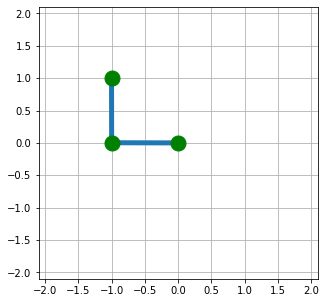

In [564]:
sim.draw(command, save_path="../logs/2link3state_ddp.gif")